In [1]:
import sys
sys.path.append("../..") 

In [2]:
import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.metrics.metrics import gaussian_eval_fn

In [3]:
def g(x):
    x = x.copy()
    x = np.log(x) - np.log(140)
    return x
def ginv(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x


In [56]:
df = pd.read_csv("../../data/mimic.csv")

In [57]:
df.shape

(692966, 54)

In [62]:
len(df.stay_id.unique())

39900

In [6]:
df.head()

,rn,subject_id,hadm_id,stay_id,timer,timer_next,timer_prev,glc,glc_next,glc_lab,...,tpn_rate,dextrose_fluid,delta_t,msk0,sum_msk0,n,gender_m,msk,timer_d,timer_next_d
0,0,12466550,23998182,30000153,2174-09-29 20:12:00+00:00,2174-09-30 13:00:00+00:00,2174-09-29 12:09:00+00:00,185.0,139.0,NaN,...,0.0,0.0,16.80,0.0,0.0,1,1.0,0.0,8.050000,24.850000
1,1,12466550,23998182,30000153,2174-09-30 13:00:00+00:00,2174-09-30 20:00:00+00:00,2174-09-29 20:12:00+00:00,139.0,137.0,NaN,...,0.0,0.0,7.00,0.0,0.0,2,1.0,0.0,24.850000,31.850000
2,3,13180007,27543152,30000213,2162-06-21 06:06:00+00:00,2162-06-21 07:00:00+00:00,2162-06-21 05:40:00+00:00,125.0,108.0,NaN,...,0.0,0.0,0.90,0.0,1.0,1,1.0,0.0,0.466667,1.366667
3,4,13180007,27543152,30000213,2162-06-21 07:00:00+00:00,2162-06-21 07:45:00+00:00,2162-06-21 06:06:00+00:00,108.0,97.0,NaN,...,0.0,0.0,0.75,0.0,1.0,2,1.0,0.0,1.366667,2.116667
4,5,13180007,27543152,30000213,2162-06-21 07:45:00+00:00,2162-06-21 08:15:00+00:00,2162-06-21 07:00:00+00:00,97.0,156.0,NaN,...,0.0,0.0,0.50,0.0,1.0,3,1.0,0.0,2.116667,2.616667


In [9]:
def get_all_predictions(path):
    df_predictions = []
    for folder in os.listdir(path):
        if folder.startswith('version') == True:
            print(folder)
            dfs = []
            files = glob.glob(os.path.join(path, folder, "predictions*"))
            for f in files:
                pred = pd.read_csv(f)
                fold = re.findall(r'\d+', f)[-1]
                pred.loc[:,'fold'] = fold
                dfs.append(pred)
            if len(dfs) > 0:
                df = pd.concat(dfs, axis=0)
                print(df.shape)
                df_predictions.append(df)
    df_prediction = pd.concat(df_predictions, axis=0)
    return df_prediction

In [10]:
df1 = get_all_predictions("../../experiments/mimic/")

version_1
(651773, 5)
version_2
(651773, 5)
version_7
(651773, 5)
version_4
(651773, 5)
version_6
(651773, 5)
version_0
(651773, 5)
version_9
(651773, 5)
version_10
version_8
(651773, 5)
version_5
(651773, 5)


In [11]:
df1 = df1.sort_values('rn')

In [12]:
df1.shape

(5865957, 5)

In [13]:
df_results = pd.merge(df1,df,how='left',on='rn')

In [14]:
del df1
del df

In [15]:
df_results.shape

(5865957, 58)

In [16]:
df_results.loc[:,'target'] = g(df_results.glc_next)

In [17]:
df_results.head()

,rn,mu,sigma,model,fold,subject_id,hadm_id,stay_id,timer,timer_next,...,dextrose_fluid,delta_t,msk0,sum_msk0,n,gender_m,msk,timer_d,timer_next_d,target
0,0,0.091097,0.260285,Catboost,0,12466550,23998182,30000153,2174-09-29 20:12:00+00:00,2174-09-30 13:00:00+00:00,...,0.0,16.8,0.0,0.0,1,1.0,0.0,8.05,24.85,-0.007168
1,0,0.165079,0.224083,IMODE,0,12466550,23998182,30000153,2174-09-29 20:12:00+00:00,2174-09-30 13:00:00+00:00,...,0.0,16.8,0.0,0.0,1,1.0,0.0,8.05,24.85,-0.007168
2,0,0.060460,0.268506,LSTMModel,0,12466550,23998182,30000153,2174-09-29 20:12:00+00:00,2174-09-30 13:00:00+00:00,...,0.0,16.8,0.0,0.0,1,1.0,0.0,8.05,24.85,-0.007168
3,0,0.045197,0.289865,FlowLSTMModel,0,12466550,23998182,30000153,2174-09-29 20:12:00+00:00,2174-09-30 13:00:00+00:00,...,0.0,16.8,0.0,0.0,1,1.0,0.0,8.05,24.85,-0.007168
4,0,0.095454,0.291507,ODEGRUModel,0,12466550,23998182,30000153,2174-09-29 20:12:00+00:00,2174-09-30 13:00:00+00:00,...,0.0,16.8,0.0,0.0,1,1.0,0.0,8.05,24.85,-0.007168


In [18]:
def gaussian_eval_fn_wrapper(x):
    res = gaussian_eval_fn(x.loc[:,['mu','sigma']].to_numpy(),y=x.target,ginv=ginv)
    return(pd.Series(res))

In [19]:
# results table

In [20]:
print(df_results.loc[:,['model','fold','target','mu','sigma']].shape)
print(df_results.loc[:,['model','fold','target','mu','sigma']].dropna().shape)

(5865957, 5)
(5864591, 5)


In [21]:
# prevent numeric overflow
#df_results.loc[df_results.sigma > 5,'sigma'] = 5.0

In [42]:
df_results.loc[(df_results.sigma > 2),'sigma'] = 2.0

In [43]:
df_results_mf = df_results.loc[df_results.msk == 0,['model','fold','target','mu','sigma']].dropna().groupby(['model','fold'])[['target','mu','sigma']]
df_metrics = df_results_mf.apply(gaussian_eval_fn_wrapper)

In [44]:
df_metrics

crps_mean   ig_mean  int_score_mean   var_pit  \
model         fold                                                  
Catboost      0      0.117784  0.150693      175.513438  0.078344   
              1      0.119476  0.146946      176.816419  0.076557   
              2      0.117929  0.150086      175.809555  0.077952   
FlowGRUModel  0      0.123157  0.052069      187.789292  0.075073   
              1      0.122995  0.076469      185.795066  0.074737   
              2      0.122121  0.031931      186.882885  0.074610   
FlowLSTMModel 0      0.120477  0.063240      184.039216  0.071612   
              1      0.121544  0.071562      184.518087  0.074462   
              2      0.120507  0.022729      184.486172  0.074505   
GRUModel      0      0.126022  0.069533      192.101642  0.078462   
              1      0.127265  0.068134      191.532778  0.074695   
              2      0.130819  0.037267      195.061921  0.076922   
IMODE         0      0.124524  0.053102      199.067965  0.087372   
              1      0.124256  0.062996      197.798679  0.086606   
              2      0.123890  0.063633      196.807773  0.086485   
LSTMModel     0      0.124461  0.103844      180.587065  0.077627   
              1      0.124247  0.104093      181.301650  0.076856   
              2      0.122215  0.120115      181.246243  0.074281   
LinearModel   0      0.133071 -0.072458      214.131760  0.066487   
              1      0.133405 -0.022447      213.387666  0.066489   
              2      0.132704 -0.023774      213.503191  0.065796   
ODEGRUModel   0      0.131976 -0.240814      217.280932  0.074197   
              1      0.129029 -0.166056      209.892614  0.071229   
              2      0.127804 -0.298373      206.306169  0.072143   
ODELSTMModel  0      0.117736  0.144068      176.318494  0.074981   
              1      0.117795  0.160231      174.697835  0.076868   
              2      0.117040  0.152254      175.323241  0.075746   

                    int_coverage  int_av_width  int_med_width       rmse  
model         fold                                                        
Catboost      0         0.941145    128.195571     109.866436  36.986908  
              1         0.945234    132.304008     112.638437  37.416764  
              2         0.942450    129.152301     110.328798  36.994278  
FlowGRUModel  0         0.943247    142.106475     120.920095  38.652472  
              1         0.944144    140.506584     120.009838  38.543426  
              2         0.943479    141.091317     120.934608  38.171022  
FlowLSTMModel 0         0.950552    145.282785     122.080774  37.475940  
              1         0.944308    140.556066     119.113394  37.864726  
              2         0.944214    140.741173     119.186740  37.524731  
GRUModel      0         0.937953    136.766178     116.456489  40.245160  
              1         0.946702    144.832440     120.715361  40.401648  
              2         0.945610    147.686213     132.891803  41.529433  
IMODE         0         0.910464    122.791756     100.750547  38.602867  
              1         0.912590    123.564573      99.612805  38.504079  
              2         0.913763    123.637023     100.206437  38.408695  
LSTMModel     0         0.945321    134.748442     115.293760  40.295894  
              1         0.946253    137.576705     116.129908  39.487866  
              2         0.950317    141.165313     119.642249  38.459890  
LinearModel   0         0.956794    167.285162     145.397626  45.025012  
              1         0.956924    166.309599     145.099249  43.464159  
              2         0.957979    167.509681     145.824045  43.867800  
ODEGRUModel   0         0.930110    160.671339     136.768385  39.794465  
              1         0.939473    159.988264     132.677638  39.325665  
              2         0.939942    156.727589     129.052967  39.206663  
ODELSTMModel  0         0.947456    135.917926     113.107415  36.82

In [45]:
df_metrics = df_metrics.reset_index()

In [46]:
df_metrics.groupby('model').mean(numeric_only=True)

,crps_mean,ig_mean,int_score_mean,var_pit,int_coverage,int_av_width,int_med_width,rmse
model,,,,,,,,
Catboost,0.118397,0.149242,176.046471,0.077618,0.942943,129.883960,110.944557,37.132650
FlowGRUModel,0.122758,0.053490,186.822414,0.074807,0.943623,141.234792,120.621514,38.455640
FlowLSTMModel,0.120843,0.052510,184.347825,0.073526,0.946358,142.193341,120.126970,37.621799
GRUModel,0.128035,0.058311,192.898780,0.076693,0.943422,143.094944,123.354551,40.725414
IMODE,0.124223,0.059910,197.891472,0.086821,0.912272,123.331117,100.189929,38.505213
LSTMModel,0.123641,0.109351,181.044986,0.076255,0.947297,137.830153,117.021972,39.414550
LinearModel,0.133060,-0.039560,213.674206,0.066257,0.957232,167.034814,145.440307,44.118990
ODEGRUModel,0.129603,-0.235081,211.159905,0.072523,0.936508,159.129064,132.832997,39.442264
ODELSTMModel,0.117523,0.152184,175.446523,0.075865,0.945472,133.034424,110.563651,36.905706


In [47]:
df_metrics.groupby('model').std(numeric_only=True)

,crps_mean,ig_mean,int_score_mean,var_pit,int_coverage,int_av_width,int_med_width,rmse
model,,,,,,,,
Catboost,0.000938,0.002011,0.683035,0.000939,0.002089,2.149722,1.485048,0.246078
FlowGRUModel,0.000557,0.022303,0.998487,0.000240,0.000466,0.809538,0.529777,0.252445
FlowLSTMModel,0.000608,0.026125,0.267739,0.001658,0.003632,2.677137,1.692442,0.211790
GRUModel,0.002489,0.018238,1.894805,0.001894,0.004768,5.663564,8.529588,0.700683
IMODE,0.000318,0.005905,1.132950,0.000481,0.001672,0.468503,0.569050,0.097091
LSTMModel,0.001239,0.009323,0.397538,0.001752,0.002657,3.215935,2.307417,0.920195
LinearModel,0.000351,0.028498,0.400442,0.000399,0.000650,0.638009,0.364278,0.810177
ODEGRUModel,0.002144,0.066345,5.596059,0.001520,0.005546,2.107596,3.860055,0.310764
ODELSTMModel,0.000420,0.008082,0.817333,0.000949,0.002464,3.003868,2.685040,0.203346


In [48]:
d = {'LinearModel':'LinearModel',
     'Catboost':'Catboost',
     'GRUModel':'TimeGap-GRU',
     'DecayGRUModel':'Decay-GRU',
     'ODEGRUModel':'ODE-GRU',
     'FlowGRUModel':'Flow-GRU',
     'LSTMModel':'TimeGap-LSTM',
     'ODELSTMModel':'ODE-LSTM',
     'FlowLSTMModel':'Flow-LSTM',
     'IMODE':'IMODE'}
hue_order = list(d.values())

In [49]:
df_metrics['model_name'] = [d[m] for m in df_metrics.model]

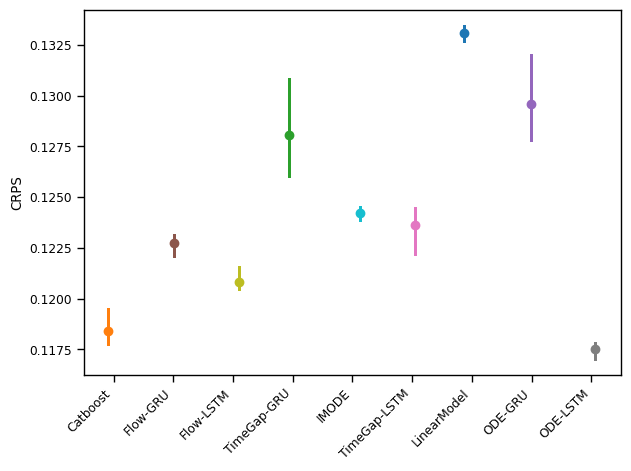

In [50]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(y="crps_mean", x="model_name",hue="model_name",hue_order=hue_order,data=df_metrics,dodge=0.25,join=True)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
#           loc="upper right", ncol=1, frameon=True)
ax.legend([],[], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('CRPS')
ax.tick_params(axis='x', rotation=45)
#ax.set_title('(B)',loc='left')
plt.xticks(ha='right')
plt.tight_layout()
f.savefig('../../results/mimic_crps.png', dpi=300)
plt.show()

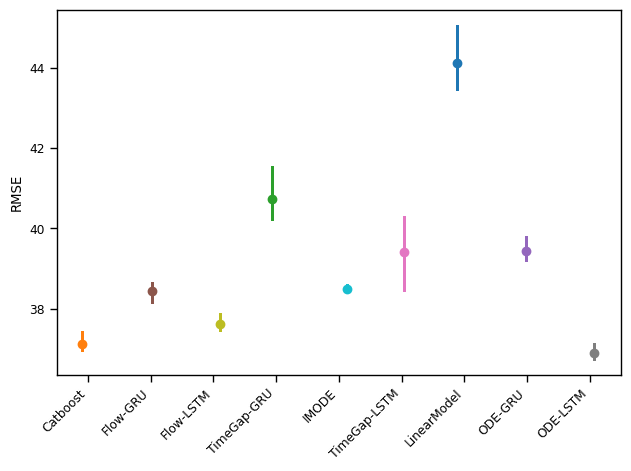

In [51]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(y="rmse", x="model_name",hue="model_name",hue_order=hue_order,data=df_metrics,dodge=0.25,join=True)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
#           loc="upper right", ncol=1, frameon=True)
ax.legend([],[], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('RMSE')
ax.tick_params(axis='x', rotation=45)
#ax.set_title('(B)',loc='left')
plt.xticks(ha='right')
plt.tight_layout()
f.savefig('../../results/mimic_rmse.png', dpi=300)
plt.show()

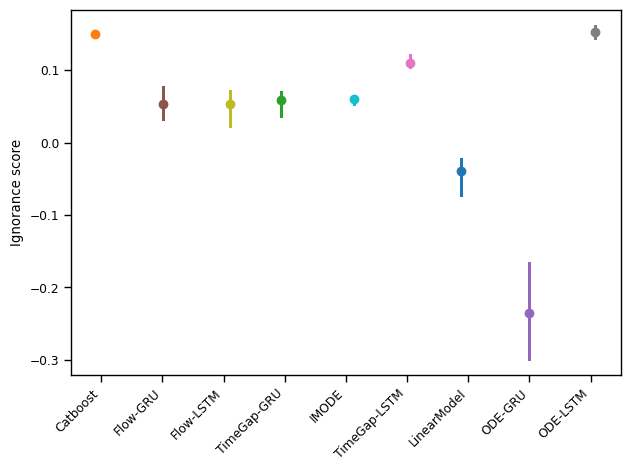

In [52]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(y="ig_mean", x="model_name",hue="model_name",hue_order=hue_order,data=df_metrics,dodge=0.25,join=True)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
#           loc="upper right", ncol=1, frameon=True)
ax.legend([],[], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('Ignorance score')
ax.tick_params(axis='x', rotation=45)
#ax.set_title('(B)',loc='left')
plt.xticks(ha='right')
plt.tight_layout()
f.savefig('../../results/mimic_ig_mean.png', dpi=300)
plt.show()

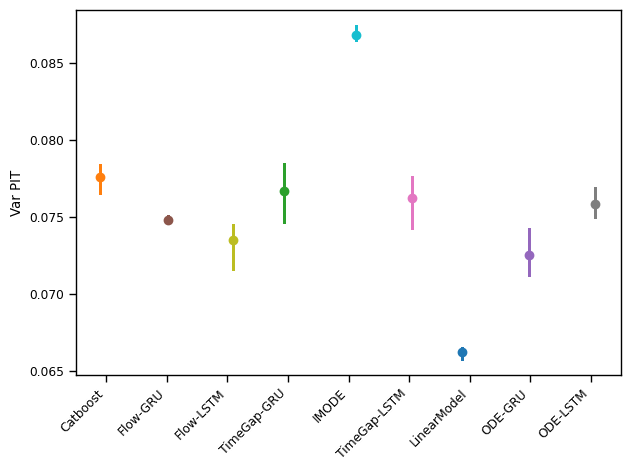

In [53]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(y="var_pit", x="model_name",hue="model_name",hue_order=hue_order,data=df_metrics,dodge=0.25,join=True)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
#           loc="upper right", ncol=1, frameon=True)
ax.legend([],[], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('Var PIT')
ax.tick_params(axis='x', rotation=45)
#ax.set_title('(B)',loc='left')
plt.xticks(ha='right')
plt.tight_layout()
f.savefig('../../results/mimic_var_pit.png', dpi=300)
plt.show()

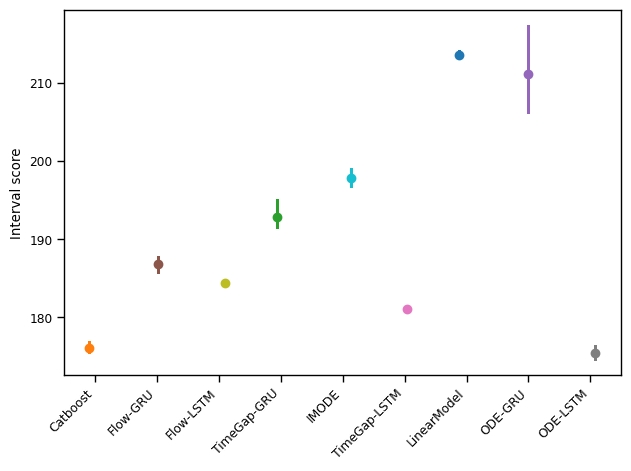

In [54]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(y="int_score_mean", x="model_name",hue="model_name",hue_order=hue_order,data=df_metrics,dodge=0.25,join=True)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
#           loc="upper right", ncol=1, frameon=True)
ax.legend([],[], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('Interval score')
ax.tick_params(axis='x', rotation=45)
#ax.set_title('(B)',loc='left')
plt.xticks(ha='right')
plt.tight_layout()
f.savefig('../../results/mimic_int_score_mean.png', dpi=300)
plt.show()

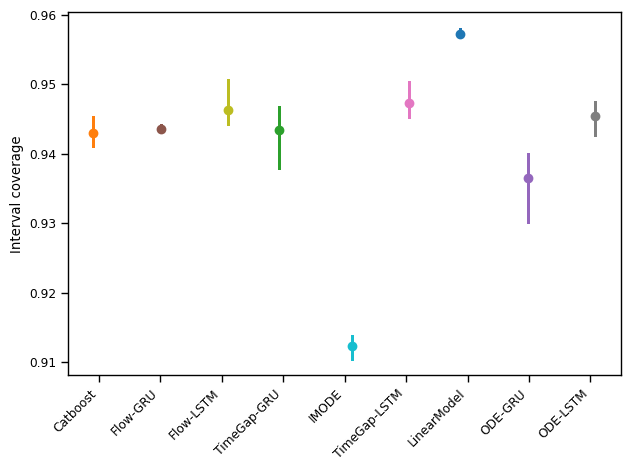

In [65]:
sns.set_context("paper")
f, ax = plt.subplots()
sns.pointplot(y="int_coverage", x="model_name",hue="model_name",hue_order=hue_order,data=df_metrics,dodge=0.25,join=True)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title="", handletextpad=0, columnspacing=1,
#           loc="upper right", ncol=1, frameon=True)
ax.legend([],[], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('Interval coverage')
ax.tick_params(axis='x', rotation=45)
#ax.set_title('(B)',loc='left')
plt.xticks(ha='right')
plt.tight_layout()
f.savefig('../../results/mimic_int_coverage_mean.png', dpi=300)
plt.show()